In [27]:
import sys
sys.path.insert(0, "../..")
import config as cfg
import gc
import os
from tqdm.notebook import tqdm
from helper import check_path, seed_everything
from collections import defaultdict

In [28]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [30]:
EXPERIMENT_FAMILY_NAME = 'keras'
EXPERIMENT_NAME = 'labse_emb'
N_RANDOM_SEEDS = 1
N_EPOCHS = 100
BATCH_SIZE = 64
N_SPLITS = 10

In [31]:
RANDOM_STATE = 77
seed_everything(RANDOM_STATE)

In [32]:
def filter_rare_categories(df: pd.DataFrame) -> pd.DataFrame:
    rare_categories = [12]
    return df.loc[~df[cfg.TARGET].isin(rare_categories)]

In [33]:

train = pd.read_pickle(os.path.join(cfg.PREPROCESSED_DATA_PATH, 'train.pkl'))
test = pd.read_pickle(os.path.join(cfg.PREPROCESSED_DATA_PATH, 'test.pkl'))

train = train.rename(columns={cfg.TEXT_COL: 'text'})
test = test.rename(columns={cfg.TEXT_COL: 'text'})

CLASSES = np.sort(train[cfg.TARGET].unique()).tolist()

# train = filter_rare_categories(train)

In [34]:
# EMB_NAME = 'smaller_LaBSE_15lang'
# train_emb = pd.read_pickle(os.path.join(cfg.DATA_PATH, EMB_NAME, 'train.pkl'))
# test_emb = pd.read_pickle(os.path.join(cfg.DATA_PATH, EMB_NAME, 'test.pkl'))

# train = train.join(train_emb)
# test = test.join(test_emb)

# del train_emb, test_emb; gc.collect()

In [35]:
X_train, y_train = train.drop(cfg.TARGET, axis=1), train[cfg.TARGET]
y_train_onecol = y_train.copy()

# y_train = pd.get_dummies(y_train)

N_OUT_CLASSES = len(CLASSES)
# assert y_train.shape[1] == N_OUT_CLASSES

In [36]:
theme_train = pd.read_csv(cfg.ORIG_TRAIN_PATH, index_col=cfg.ID_COL, usecols=[cfg.ID_COL, cfg.THEME_COL])
theme_train = theme_train[cfg.THEME_COL].astype('category').cat.codes
N_THEMES = theme_train.nunique()
# theme_train = pd.get_dummies(theme_train)
# theme_train.columns = [f'theme_{i}' for i in range(theme_train.shape[1])]


In [37]:
pred_proba_oof = pd.DataFrame(data=np.zeros(shape=(len(train), len(CLASSES))), index=train.index, columns=CLASSES)
pred_proba_test = pd.DataFrame(data=np.zeros(shape=(len(test), len(CLASSES))), index=test.index, columns=CLASSES)

In [38]:
from typing import Optional


def df_to_dataset(data: pd.DataFrame, labels: Optional[pd.DataFrame]=None, shuffle: bool=True, batch_size: int=32, labels2: Optional[pd.DataFrame]=None):
  df = data.copy()
  df = {key: value.values[:, tf.newaxis] for key, value in data.items()}
  
  if labels is None:
    ds = tf.data.Dataset.from_tensor_slices((dict(df),))
  else:
    ds = tf.data.Dataset.from_tensor_slices((
      dict(df), 
      {
        'category_out': labels, 
        'theme_out': labels2
        }
        ))
        
  if shuffle:
    ds = ds.shuffle(buffer_size=len(data))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds


def get_keras_input(
    data: pd.DataFrame,
    labels: Optional[pd.DataFrame] = None,
    labels2: Optional[pd.DataFrame] = None,
    shuffle=False
    ) -> tf.data.Dataset:
    return df_to_dataset(
        data=data,
        labels=labels,
        labels2=labels2,
        shuffle=shuffle, 
        batch_size=BATCH_SIZE)
        


In [39]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer("https://tfhub.dev/jeongukjae/smaller_LaBSE_15lang_preprocess/1", name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/smaller_LaBSE_15lang/1", trainable=False, name='encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.BatchNormalization()(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(300, activation=None)(net)
    net = tf.keras.layers.LeakyReLU(alpha=0.5)(net)
    net = tf.keras.layers.BatchNormalization()(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    category_out = tf.keras.layers.Dense(N_OUT_CLASSES, activation=None, name='category_out')(net)
    theme_out = tf.keras.layers.Dense(N_THEMES, activation=None, name='theme_out')(net)
    model = tf.keras.Model(
        text_input, 
        outputs={
            'category_out': category_out, 
            'theme_out': theme_out
            })

    loss = {
        'category_out': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='category_out'),
        'theme_out': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='theme_out')
        }
    # metrics = tf.keras.metrics.AUC(from_logits=True, name='auc')

    epochs = N_EPOCHS
    n = (len(train) // cfg.N_SPLITS) * (cfg.N_SPLITS-1)
    steps_per_epoch = n // BATCH_SIZE
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    init_lr = 3e-4
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')

    model.compile(optimizer=optimizer,
                         loss=loss,
                         loss_weights={"category_out": 2.0, "theme_out": 0.2}
                        #  metrics=metrics
                         )
    return model

In [40]:
leak_test = pd.read_pickle(os.path.join(cfg.DATA_PATH, 'test_leak.pkl'))
leak_mask = leak_test.notnull()

In [41]:
cv = StratifiedKFold(n_splits=N_SPLITS, random_state=cfg.RANDOM_STATE, shuffle=True)

test_pool = get_keras_input(
        data=test,
        shuffle=False
        )


metrics = defaultdict(list)
fold = 0
for train_idx, val_idx in tqdm(cv.split(X_train, y_train_onecol), total=N_SPLITS):

    train_pool = get_keras_input(
        data=X_train.iloc[train_idx], 
        labels=y_train.iloc[train_idx],
        labels2=theme_train.iloc[train_idx],
        shuffle=True
        )

    val_pool = get_keras_input(
        data=X_train.iloc[val_idx], 
        labels=y_train.iloc[val_idx],
        labels2=theme_train.iloc[val_idx],
        shuffle=False
        )
    
        
    for random_seed in tqdm(range(N_RANDOM_SEEDS), total=N_RANDOM_SEEDS):

        clf = build_classifier_model()
        
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_category_out_loss', patience=3, min_delta=1e-5, mode='auto', restore_best_weights=True)
        clf.fit(x=train_pool, validation_data=val_pool, epochs=N_EPOCHS, callbacks=[early_stopping])
        
        model_name = f'{EXPERIMENT_NAME}_fold_{fold}_rs_{random_seed}'
        model_path = os.path.join(cfg.MODELS_PATH, EXPERIMENT_FAMILY_NAME, EXPERIMENT_NAME)
        check_path(model_path)
        clf.save(os.path.join(model_path, model_name), include_optimizer=False)
        
        pred_proba_oof_val = tf.nn.softmax(clf.predict(val_pool)['category_out']).numpy()
        pred_proba_oof_train = tf.nn.softmax(clf.predict(train_pool)['category_out']).numpy()
        pred_proba_oof.iloc[val_idx, :] += pred_proba_oof_val
        pred_proba_test.iloc[:, :] += tf.nn.softmax(clf.predict(test_pool)['category_out']).numpy()

        y_val_oof = y_train_onecol.iloc[val_idx]

        val_auc = roc_auc_score(y_val_oof, pred_proba_oof_val , multi_class='ovo', labels=CLASSES)
        metrics['val_auc'].append(val_auc)
        print('val auc', val_auc)

        leak_test_auc_score = roc_auc_score(leak_test.loc[leak_mask], pred_proba_test.loc[leak_mask] / (fold + 1), multi_class='ovo', labels=CLASSES)
        metrics['leak_test_auc_score'].append(leak_test_auc_score)
        print('leak_test_auc_score', leak_test_auc_score)
        
        del clf; gc.collect()
    del train_pool,val_pool; gc.collect() 
        
    fold += 1
pred_proba_oof /= N_RANDOM_SEEDS
pred_proba_test /= (N_SPLITS * N_RANDOM_SEEDS)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/as/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
29/29 [==============================] - 44s 1s/step - loss: 8.6676 - category_out_loss: 3.7400 - theme_out_loss: 5.9375 - val_loss: 6.4972 - val_category_out_loss: 2.7335 - val_theme_out_loss: 5.1505
Epoch 2/100
29/29 [==============================] - 34s 1s/step - loss: 7.7149 - category_out_loss: 3.2694 - theme_out_loss: 5.8805 - val_loss: 5.9007 - val_category_out_loss: 2.4377 - val_theme_out_loss: 5.1263
Epoch 3/100
29/29 [==============================] - 36s 1s/step - loss: 6.2871 - category_out_loss: 2.5718 - theme_out_loss: 5.7179 - val_loss: 5.1400 - val_category_out_loss: 2.0628 - val_theme_out_loss: 5.0725
Epoch 4/100
29/29 [==============================] - 38s 1s/step - loss: 5.0616 - category_out_loss: 1.9784 - theme_out_loss: 5.5238 - val_loss: 4.4490 - val_category_out_loss: 1.7280 - val_theme_out_loss: 4.9652
Epoch 5/100
29/29 [==============================] - 42s 1s/step - loss: 4.2275 - category_out_loss: 1.5865 - theme_out_loss: 5.2730 - val_loss: 3.9

16/16 [==============================] - 23s 1s/step
val auc 0.8990138153224092
leak_test_auc_score 0.8769087338768746


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
29/29 [==============================] - 75s 2s/step - loss: 8.7643 - category_out_loss: 3.7974 - theme_out_loss: 5.8478 - val_loss: 7.0583 - val_category_out_loss: 3.0056 - val_theme_out_loss: 5.2354
Epoch 2/100
29/29 [==============================] - 52s 2s/step - loss: 7.7349 - category_out_loss: 3.2827 - theme_out_loss: 5.8478 - val_loss: 6.2358 - val_category_out_loss: 2.5975 - val_theme_out_loss: 5.2040
Epoch 3/100
29/29 [==============================] - 49s 2s/step - loss: 6.2797 - category_out_loss: 2.5694 - theme_out_loss: 5.7040 - val_loss: 5.2393 - val_category_out_loss: 2.1051 - val_theme_out_loss: 5.1458
Epoch 4/100
29/29 [==============================] - 51s 2s/step - loss: 5.0078 - category_out_loss: 1.9523 - theme_out_loss: 5.5161 - val_loss: 4.4018 - val_category_out_loss: 1.6975 - val_theme_out_loss: 5.0333
Epoch 5/100
29/29 [==============================] - 57s 2s/step - loss: 4.2362 - category_out_loss: 1.6002 - theme_out_loss: 5.1794 - val_loss: 3.7

16/16 [==============================] - 32s 2s/step
val auc 0.9070928606363876
leak_test_auc_score 0.8621747811724846


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
29/29 [==============================] - 57s 1s/step - loss: 8.8361 - category_out_loss: 3.8283 - theme_out_loss: 5.8973 - val_loss: 6.7696 - val_category_out_loss: 2.8733 - val_theme_out_loss: 5.1150
Epoch 2/100
29/29 [==============================] - 44s 2s/step - loss: 7.8350 - category_out_loss: 3.3368 - theme_out_loss: 5.8070 - val_loss: 6.1141 - val_category_out_loss: 2.5483 - val_theme_out_loss: 5.0875
Epoch 3/100
29/29 [==============================] - 47s 2s/step - loss: 6.3563 - category_out_loss: 2.6098 - theme_out_loss: 5.6838 - val_loss: 5.1724 - val_category_out_loss: 2.0834 - val_theme_out_loss: 5.0276
Epoch 4/100
29/29 [==============================] - 49s 2s/step - loss: 5.0413 - category_out_loss: 1.9742 - theme_out_loss: 5.4647 - val_loss: 4.4078 - val_category_out_loss: 1.7126 - val_theme_out_loss: 4.9125
Epoch 5/100
29/29 [==============================] - 52s 2s/step - loss: 4.2564 - category_out_loss: 1.6168 - theme_out_loss: 5.1139 - val_loss: 3.8

16/16 [==============================] - 23s 1s/step
val auc 0.9495849977155779
leak_test_auc_score 0.8636623666563119


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
29/29 [==============================] - 54s 1s/step - loss: 8.4891 - category_out_loss: 3.6707 - theme_out_loss: 5.7386 - val_loss: 6.4179 - val_category_out_loss: 2.6846 - val_theme_out_loss: 5.2434
Epoch 2/100
29/29 [==============================] - 55s 2s/step - loss: 7.6043 - category_out_loss: 3.2306 - theme_out_loss: 5.7152 - val_loss: 5.9858 - val_category_out_loss: 2.4737 - val_theme_out_loss: 5.1922
Epoch 3/100
29/29 [==============================] - 37s 1s/step - loss: 6.1181 - category_out_loss: 2.5010 - theme_out_loss: 5.5805 - val_loss: 5.2362 - val_category_out_loss: 2.1073 - val_theme_out_loss: 5.1078
Epoch 4/100
29/29 [==============================] - 45s 2s/step - loss: 5.0046 - category_out_loss: 1.9688 - theme_out_loss: 5.3352 - val_loss: 4.5790 - val_category_out_loss: 1.7932 - val_theme_out_loss: 4.9631
Epoch 5/100
29/29 [==============================] - 36s 1s/step - loss: 4.1930 - category_out_loss: 1.5892 - theme_out_loss: 5.0730 - val_loss: 4.0

16/16 [==============================] - 20s 1s/step
val auc 0.8900954043476363
leak_test_auc_score 0.867125452050154


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
29/29 [==============================] - 62s 2s/step - loss: 9.1320 - category_out_loss: 3.9674 - theme_out_loss: 5.9859 - val_loss: 6.7766 - val_category_out_loss: 2.8689 - val_theme_out_loss: 5.1940
Epoch 2/100
29/29 [==============================] - 45s 2s/step - loss: 8.1523 - category_out_loss: 3.4843 - theme_out_loss: 5.9183 - val_loss: 6.0441 - val_category_out_loss: 2.5046 - val_theme_out_loss: 5.1742
Epoch 3/100
29/29 [==============================] - 45s 2s/step - loss: 6.5332 - category_out_loss: 2.6855 - theme_out_loss: 5.8105 - val_loss: 5.0833 - val_category_out_loss: 2.0294 - val_theme_out_loss: 5.1222
Epoch 4/100
29/29 [==============================] - 47s 2s/step - loss: 5.1673 - category_out_loss: 2.0230 - theme_out_loss: 5.6068 - val_loss: 4.2330 - val_category_out_loss: 1.6158 - val_theme_out_loss: 5.0076
Epoch 5/100
29/29 [==============================] - 42s 1s/step - loss: 4.3092 - category_out_loss: 1.6291 - theme_out_loss: 5.2547 - val_loss: 3.7

16/16 [==============================] - 21s 1s/step
val auc 0.9166185254803676
leak_test_auc_score 0.8720778120576873


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
29/29 [==============================] - 57s 2s/step - loss: 8.7176 - category_out_loss: 3.7746 - theme_out_loss: 5.8421 - val_loss: 6.8227 - val_category_out_loss: 2.8998 - val_theme_out_loss: 5.1150
Epoch 2/100
29/29 [==============================] - 49s 2s/step - loss: 7.7993 - category_out_loss: 3.3210 - theme_out_loss: 5.7866 - val_loss: 5.9450 - val_category_out_loss: 2.4635 - val_theme_out_loss: 5.0900
Epoch 3/100
29/29 [==============================] - 40s 1s/step - loss: 6.2536 - category_out_loss: 2.5571 - theme_out_loss: 5.6971 - val_loss: 4.9016 - val_category_out_loss: 1.9488 - val_theme_out_loss: 5.0200
Epoch 4/100
29/29 [==============================] - 46s 2s/step - loss: 5.0290 - category_out_loss: 1.9688 - theme_out_loss: 5.4570 - val_loss: 4.1216 - val_category_out_loss: 1.5728 - val_theme_out_loss: 4.8803
Epoch 5/100
29/29 [==============================] - 37s 1s/step - loss: 4.2480 - category_out_loss: 1.6065 - theme_out_loss: 5.1753 - val_loss: 3.6

16/16 [==============================] - 19s 1s/step
val auc 0.8979467243283034
leak_test_auc_score 0.8690133142351155


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
29/29 [==============================] - 65s 2s/step - loss: 8.7417 - category_out_loss: 3.7851 - theme_out_loss: 5.8578 - val_loss: 7.0162 - val_category_out_loss: 2.9886 - val_theme_out_loss: 5.1953
Epoch 2/100
29/29 [==============================] - 44s 2s/step - loss: 7.8139 - category_out_loss: 3.3253 - theme_out_loss: 5.8164 - val_loss: 6.2106 - val_category_out_loss: 2.5894 - val_theme_out_loss: 5.1587
Epoch 3/100
29/29 [==============================] - 44s 1s/step - loss: 6.2946 - category_out_loss: 2.5806 - theme_out_loss: 5.6664 - val_loss: 5.1962 - val_category_out_loss: 2.0891 - val_theme_out_loss: 5.0904
Epoch 4/100
29/29 [==============================] - 49s 2s/step - loss: 5.0927 - category_out_loss: 1.9982 - theme_out_loss: 5.4815 - val_loss: 4.3636 - val_category_out_loss: 1.6858 - val_theme_out_loss: 4.9596
Epoch 5/100
29/29 [==============================] - 44s 2s/step - loss: 4.1922 - category_out_loss: 1.5788 - theme_out_loss: 5.1733 - val_loss: 3.8

16/16 [==============================] - 29s 2s/step
val auc 0.8224479580214663
leak_test_auc_score 0.8687693576350647


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
29/29 [==============================] - 54s 1s/step - loss: 8.6709 - category_out_loss: 3.7569 - theme_out_loss: 5.7850 - val_loss: 6.8804 - val_category_out_loss: 2.9234 - val_theme_out_loss: 5.1678
Epoch 2/100
29/29 [==============================] - 50s 2s/step - loss: 7.6666 - category_out_loss: 3.2591 - theme_out_loss: 5.7421 - val_loss: 5.9806 - val_category_out_loss: 2.4772 - val_theme_out_loss: 5.1313
Epoch 3/100
29/29 [==============================] - 42s 1s/step - loss: 6.2489 - category_out_loss: 2.5635 - theme_out_loss: 5.6096 - val_loss: 4.9344 - val_category_out_loss: 1.9610 - val_theme_out_loss: 5.0622
Epoch 4/100
29/29 [==============================] - 45s 2s/step - loss: 5.0640 - category_out_loss: 1.9878 - theme_out_loss: 5.4425 - val_loss: 4.1809 - val_category_out_loss: 1.5970 - val_theme_out_loss: 4.9344
Epoch 5/100
29/29 [==============================] - 37s 1s/step - loss: 4.1723 - category_out_loss: 1.5769 - theme_out_loss: 5.0919 - val_loss: 3.7

16/16 [==============================] - 20s 1s/step
val auc 0.9192427305537209
leak_test_auc_score 0.869575647134414


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
29/29 [==============================] - 67s 2s/step - loss: 8.8190 - category_out_loss: 3.8271 - theme_out_loss: 5.8238 - val_loss: 6.7007 - val_category_out_loss: 2.8289 - val_theme_out_loss: 5.2150
Epoch 2/100
29/29 [==============================] - 41s 1s/step - loss: 7.9374 - category_out_loss: 3.3901 - theme_out_loss: 5.7864 - val_loss: 6.0657 - val_category_out_loss: 2.5144 - val_theme_out_loss: 5.1847
Epoch 3/100
29/29 [==============================] - 48s 2s/step - loss: 6.4184 - category_out_loss: 2.6405 - theme_out_loss: 5.6869 - val_loss: 5.1342 - val_category_out_loss: 2.0546 - val_theme_out_loss: 5.1247
Epoch 4/100
29/29 [==============================] - 42s 1s/step - loss: 5.0691 - category_out_loss: 1.9889 - theme_out_loss: 5.4561 - val_loss: 4.3267 - val_category_out_loss: 1.6628 - val_theme_out_loss: 5.0060
Epoch 5/100
29/29 [==============================] - 45s 2s/step - loss: 4.3446 - category_out_loss: 1.6555 - theme_out_loss: 5.1683 - val_loss: 3.7

16/16 [==============================] - 21s 1s/step
val auc 0.8969459093687077
leak_test_auc_score 0.8696117924023765


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
29/29 [==============================] - 61s 2s/step - loss: 8.5567 - category_out_loss: 3.6959 - theme_out_loss: 5.8251 - val_loss: 6.3601 - val_category_out_loss: 2.6716 - val_theme_out_loss: 5.0847
Epoch 2/100
29/29 [==============================] - 50s 2s/step - loss: 7.6048 - category_out_loss: 3.2217 - theme_out_loss: 5.8065 - val_loss: 5.6256 - val_category_out_loss: 2.3067 - val_theme_out_loss: 5.0613
Epoch 3/100
29/29 [==============================] - 44s 2s/step - loss: 6.1864 - category_out_loss: 2.5238 - theme_out_loss: 5.6934 - val_loss: 4.8025 - val_category_out_loss: 1.9011 - val_theme_out_loss: 5.0015
Epoch 4/100
29/29 [==============================] - 45s 2s/step - loss: 4.8692 - category_out_loss: 1.8900 - theme_out_loss: 5.4461 - val_loss: 4.1446 - val_category_out_loss: 1.5845 - val_theme_out_loss: 4.8784
Epoch 5/100
29/29 [==============================] - 38s 1s/step - loss: 4.2268 - category_out_loss: 1.6005 - theme_out_loss: 5.1295 - val_loss: 3.7

16/16 [==============================] - 22s 1s/step
val auc 0.83599325225735
leak_test_auc_score 0.8694012041464431


In [42]:
# 0.8651044661502603

In [43]:
oof_auc_score = roc_auc_score(y_train, pred_proba_oof , multi_class='ovo', labels=CLASSES)
print('oof_auc_score', oof_auc_score)
print('scores', metrics['val_auc'])
print('mean', np.mean(metrics['val_auc']), 'std', np.std(metrics['val_auc']))

oof_auc_score 0.832839747715579
scores [0.8990138153224092, 0.9070928606363876, 0.9495849977155779, 0.8900954043476363, 0.9166185254803676, 0.8979467243283034, 0.8224479580214663, 0.9192427305537209, 0.8969459093687077, 0.83599325225735]
mean 0.8934982178031927 std 0.03599514825483201


In [44]:
# 0.8263713180555257

In [45]:
leak_test = pd.read_pickle(os.path.join(cfg.DATA_PATH, 'test_leak.pkl'))
notnull = leak_test.notnull()
leak_test_auc_score = roc_auc_score(leak_test.loc[notnull], pred_proba_test.loc[notnull], multi_class='ovo', labels=CLASSES)
print('leak_test_auc_score', leak_test_auc_score)


leak_test_auc_score 0.8694012041464431


In [46]:
# 0.8659094099087034

In [47]:
submission = pd.read_csv(cfg.SAMPLE_SUBMIT_PATH).set_index('id')
assert submission.index.equals(pred_proba_test.index)
submission[cfg.TARGET] = pred_proba_test.idxmax(1)

submission_path = os.path.join(cfg.SUBMISSION_PATH, EXPERIMENT_FAMILY_NAME)
check_path(submission_path)
submission.to_csv(os.path.join(submission_path, f'{EXPERIMENT_NAME}.csv'))

pred_proba_oof_path = os.path.join(cfg.OOF_PRED_PATH, EXPERIMENT_FAMILY_NAME)
check_path(pred_proba_oof_path)
pred_proba_oof.to_pickle(os.path.join(pred_proba_oof_path, f'{EXPERIMENT_NAME}.pkl'))

pred_proba_test_path = os.path.join(cfg.TEST_PRED_PATH, EXPERIMENT_FAMILY_NAME)
check_path(pred_proba_test_path)
pred_proba_test.to_pickle(os.path.join(pred_proba_test_path, f'{EXPERIMENT_NAME}.pkl'))

In [48]:
import seaborn as sns
from matplotlib import pyplot as plt

In [49]:
trn_target_count = y_train.value_counts().rename('train_true')
trn_pred_count = pred_proba_oof.idxmax(1).value_counts().rename('train_pred')

In [50]:
tst_target_count = leak_test.loc[leak_mask].astype('int').value_counts().rename('test_true')
tst_pred_count = submission.loc[leak_mask, cfg.TARGET].value_counts().rename('test_pred')

<AxesSubplot:>

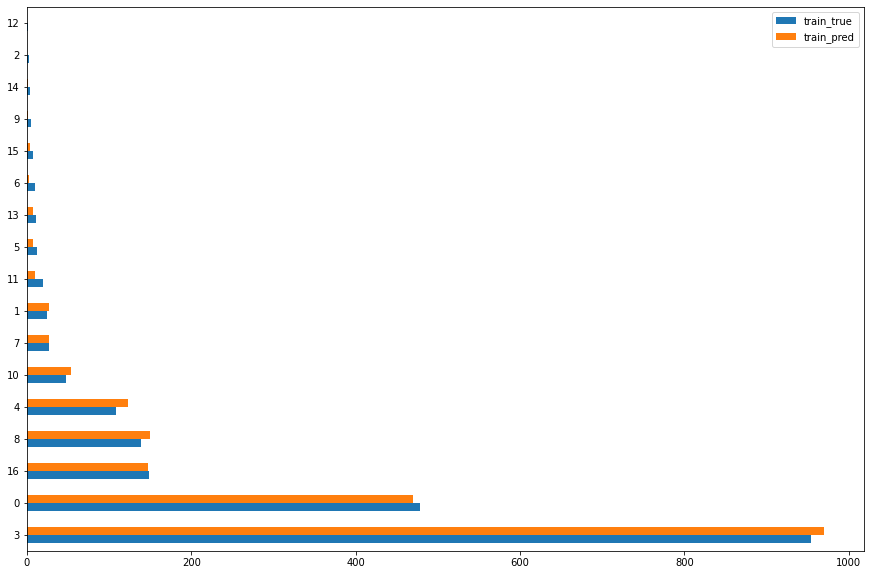

In [51]:
pd.concat([trn_target_count, trn_pred_count], axis=1).plot(kind='barh', figsize=(15,10))

<AxesSubplot:>

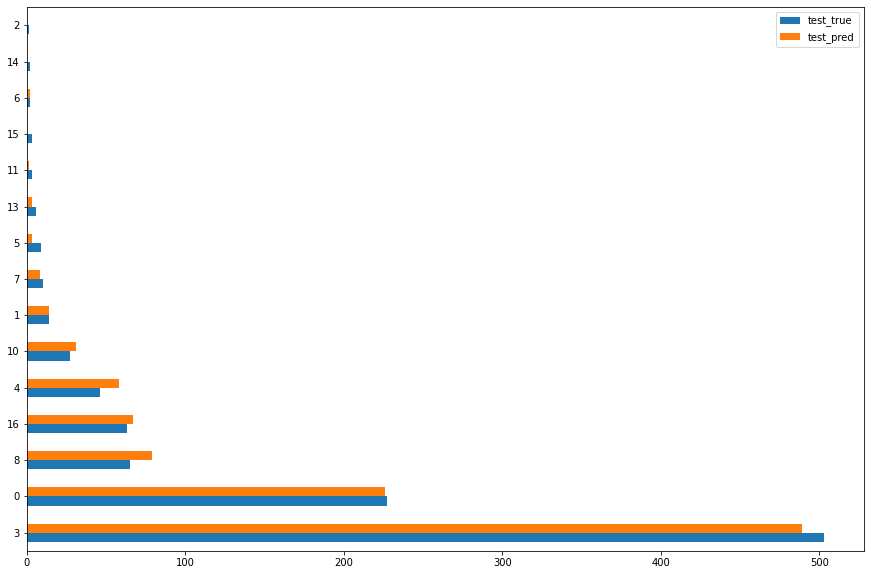

In [52]:
pd.concat([tst_target_count, tst_pred_count], axis=1).plot(kind='barh', figsize=(15,10))